In [1]:
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, RNN, InputLayer, SimpleRNN
from pickle import load
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pickle import dump
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
host='' # MongoDB Host
user='' 
password =''

In [3]:
client = MongoClient(host=host, username=user, password=password)
db = client.Ebalance
col = db["emv210"]
data1 = col.find({},{"datetime" : 1, "kwh_p_tot_r" : 1}).sort("_id", -1)
list_cur = list(data1)
df = pd.DataFrame(list_cur)

In [4]:
df_t = df[["datetime", "kwh_p_tot_r",]]
df_t.set_index(["datetime"])
df_t.head()

,datetime,kwh_p_tot_r
0,2022/06/02 12:45:00,45.9
1,2022/06/02 12:30:00,47.4
2,2022/06/02 12:15:00,46.7
3,2022/06/02 12:00:00,47.6
4,2022/06/02 11:45:00,47.0


In [5]:
db = client.Ebalance
col = db["openweather"]
column_names = ["datetime","weather", "temp_min", "temp_max", "pressure", "humidity", "wind"]


df2 = pd.DataFrame(columns = column_names)

data = col.find()
df2 = pd.DataFrame(data,columns = column_names)
df2.head()

,datetime,weather,temp_min,temp_max,pressure,humidity,wind
0,2022/01/27 12:00:00,Clouds,13.24,16.09,1024,58,4.92
1,2022/01/27 12:15:00,Clouds,13.24,16.65,1024,59,3.58
2,2022/01/27 12:30:00,Clouds,14.73,16.65,1024,66,4.92
3,2022/01/27 12:45:00,Clouds,15.29,17.21,1024,65,2.24
4,2022/01/27 13:15:00,Clouds,15.70,17.47,1023,65,3.13


In [6]:
df_final = pd.merge(left=df, right=df2, left_on=["datetime"], right_on=[ "datetime"])
df_final.head()

,_id,datetime,kwh_p_tot_r,weather,temp_min,temp_max,pressure,humidity,wind
0,629894ae4c1dd69e801c771b,2022/06/02 12:45:00,45.9,Clouds,26.02,30.25,1013,46,4.63
1,6298912a4c1dd69e801c7715,2022/06/02 12:30:00,47.4,Clouds,26.02,29.69,1013,46,4.92
2,62988da64c1dd69e801c770f,2022/06/02 12:15:00,46.7,Clouds,25.46,29.14,1013,47,4.63
3,62988a224c1dd69e801c7709,2022/06/02 12:00:00,47.6,Clouds,25.46,28.58,1013,49,5.14
4,6298869e4c1dd69e801c7703,2022/06/02 11:45:00,47.0,Clouds,24.91,27.51,1013,50,5.14


In [7]:
df_final['datetime'] = pd.to_datetime(df_final.datetime)
df_final['datetime'] = df_final['datetime'].dt.strftime('%d/%m/%Y %H:%M:%S')
df_final["day"] = df_final["datetime"].str[0:2]
df_final["month"] = df_final["datetime"].str[3:5]
df_final["year"] = df_final["datetime"].str[6:10]
df_final["hour"] = df_final["datetime"].str[11:13]
df_final["minute"] = df_final["datetime"].str[14:16]
df_final["second"] = df_final["datetime"].str[17:19]
df_final= df_final.drop(['datetime', "_id"], axis = 1)

In [8]:
df_final["weather"] = df_final["weather"].replace("Clouds", 0)
df_final["weather"] = df_final["weather"].replace("Clear", 1)
df_final["weather"] = df_final["weather"].replace("Rain", 2)
df_final["weather"] = df_final["weather"].replace("Drizzle", 3)
df_final["weather"] = df_final["weather"].replace("Mist", 4)
df_final["weather"] = df_final["weather"].replace("Thunderstorm", 5)
df_final["weather"] = df_final["weather"].replace("Haze", 6)
df_final["weather"] = df_final["weather"].replace("Fog", 7)

In [9]:
df_final.astype('float32').dtypes

kwh_p_tot_r    float32
weather        float32
temp_min       float32
temp_max       float32
pressure       float32
humidity       float32
wind           float32
day            float32
month          float32
year           float32
hour           float32
minute         float32
second         float32
dtype: object

In [10]:
len(df_final.index)
df_final["prev_kwh_1"]= 0
df_final["prev_kwh_2"]= 0
df_final["prev_kwh_3"]= 0
df_final["prev_kwh_4"]= 0
df_final["prev_kwh_5"]= 0
df_final["prev_kwh_6"]= 0
df_final["prev_kwh_7"]= 0
df_final["prev_kwh_8"]= 0
df_final["pred_kwh_1"]= 0
df_final["pred_kwh_2"]= 0
df_final["pred_kwh_3"]= 0
df_final["pred_kwh_4"]= 0


for index in df_final.index:
    if index >= 32 and index < len(df_final.index)-4:
        
        df_final["prev_kwh_1"][index]= df_final["kwh_p_tot_r"][index-4]
        df_final["prev_kwh_2"][index]= df_final["kwh_p_tot_r"][index-8]
        df_final["prev_kwh_3"][index]= df_final["kwh_p_tot_r"][index-12]
        df_final["prev_kwh_4"][index]= df_final["kwh_p_tot_r"][index-16]
        df_final["prev_kwh_5"][index]= df_final["kwh_p_tot_r"][index-20]
        df_final["prev_kwh_6"][index]= df_final["kwh_p_tot_r"][index-24]
        df_final["prev_kwh_7"][index]= df_final["kwh_p_tot_r"][index-28]
        df_final["prev_kwh_8"][index]= df_final["kwh_p_tot_r"][index-32]
        
        df_final["pred_kwh_1"][index]= df_final["kwh_p_tot_r"][index+1]
        df_final["pred_kwh_2"][index]= df_final["kwh_p_tot_r"][index+2]
        df_final["pred_kwh_3"][index]= df_final["kwh_p_tot_r"][index+3]
        df_final["pred_kwh_4"][index]= df_final["kwh_p_tot_r"][index+4]


        
        #print(index)
df_final.drop(df_final.tail(4).index,inplace = True)
df_final.drop(df_final.head(32).index,inplace = True)
df_final.tail(32)

/tmp/ipykernel_2743194/635138436.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["prev_kwh_1"][index]= df_final["kwh_p_tot_r"][index-4]
/tmp/ipykernel_2743194/635138436.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["prev_kwh_2"][index]= df_final["kwh_p_tot_r"][index-8]
/tmp/ipykernel_2743194/635138436.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["prev_kwh_3"][index]= df_final["kwh_p_tot_r"

,kwh_p_tot_r,weather,temp_min,temp_max,pressure,humidity,wind,day,month,year,...,prev_kwh_3,prev_kwh_4,prev_kwh_5,prev_kwh_6,prev_kwh_7,prev_kwh_8,pred_kwh_1,pred_kwh_2,pred_kwh_3,pred_kwh_4
2162,24.9,1,16.02,18.89,1022,67,0.89,05,05,2022,...,26,25,30,26,29,29,29,25,23,29
2163,29.3,1,16.02,18.89,1022,66,1.79,05,05,2022,...,30,26,25,30,24,29,25,23,29,24
2164,25.1,1,16.57,17.76,1023,77,1.03,05,05,2022,...,25,31,26,26,29,25,23,29,24,24
2165,23.9,1,17.09,18.03,1022,77,1.54,05,05,2022,...,25,26,30,25,25,23,29,24,24,34
2166,29.4,1,17.09,20.00,1021,67,1.54,05,05,2022,...,28,26,25,30,26,29,24,24,34,28
2167,24.6,1,16.95,20.00,1021,65,1.54,05,05,2022,...,24,30,26,25,30,24,24,34,28,24
2168,24.3,1,17.51,20.56,1021,65,2.06,05,05,2022,...,24,25,31,26,26,29,34,28,24,26
2169,34.0,1,18.06,20.56,1021,67,2.57,05,05,2022,...,29,25,26,30,25,25,28,24,26,24
2170,28.7,1,18.06,20.56,1021,67,2.57,05,05,2022,...,23,28,26,25,30,26,24,26,24,25
2171,24.8,1,18.06,21.12,1021,66,2.57,05,05,2022,...,24,24,30,26,25,30,26,24,25,28


In [11]:
labels=np.array([df_final['pred_kwh_1'], df_final['pred_kwh_2'], df_final['pred_kwh_3'], df_final['pred_kwh_4']])
features = df_final.iloc[:,:-4]
X=features
y=np.ravel(labels)

In [12]:
X

,kwh_p_tot_r,weather,temp_min,temp_max,pressure,humidity,wind,day,month,year,...,minute,second,prev_kwh_1,prev_kwh_2,prev_kwh_3,prev_kwh_4,prev_kwh_5,prev_kwh_6,prev_kwh_7,prev_kwh_8
32,25.6,1,19.69,22.78,1012,64,6.69,02,06,2022,...,45,00,24,26,31,39,44,44,47,45
33,23.8,1,19.69,23.34,1011,63,7.20,02,06,2022,...,30,00,24,24,27,38,43,44,45,47
34,24.1,1,19.69,23.34,1011,63,7.20,02,06,2022,...,15,00,24,25,26,33,42,46,45,46
35,24.4,1,19.35,23.34,1012,62,6.17,02,06,2022,...,00,00,22,23,29,30,42,45,46,47
36,24.8,1,19.91,23.34,1012,61,6.17,02,06,2022,...,45,00,25,24,26,31,39,44,44,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,31.6,0,20.00,21.36,1020,70,4.12,05,05,2022,...,15,00,30,29,28,24,34,23,24,29
2190,32.8,0,20.00,21.92,1020,70,4.12,05,05,2022,...,00,00,31,31,28,25,28,29,24,23
2191,32.1,0,19.45,23.80,1020,70,4.12,05,05,2022,...,45,00,32,33,30,28,24,24,29,24
2192,33.6,0,20.00,21.65,1020,68,3.60,05,05,2022,...,30,00,32,31,30,26,26,24,25,28


In [13]:
y = labels.reshape((len(features), 4))
y

array([[23, 24, 24, 24],
       [23, 25, 23, 24],
       [25, 23, 24, 24],
       ...,
       [31, 32, 32, 31],
       [32, 32, 33, 32],
       [33, 33, 34, 34]])

In [14]:
X_train, X_aux, y_train, Y_aux = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_aux, Y_aux, test_size=0.5, random_state=42, shuffle=True)

In [15]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [18]:
def build_model_dense():
    model = Sequential([
    Dense(64, activation='relu', input_shape=[len(features.columns)]),
    Dense(512, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [19]:
def build_model_lstm():
    model = Sequential([
    LSTM(64, input_shape=(None, 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [21]:
def build_model_simplernn():
    model = Sequential([
    SimpleRNN(64, input_shape=(None, 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [22]:
def plot_history(history, ylim=10000, ylim2=10000):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,ylim])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,ylim2])
    plt.legend()
    plt.show()

In [23]:
EPOCHS = 8000
BATCH = 1

In [24]:
model_dense = build_model_dense()
model_dense.summary()

2022-06-02 10:57:21.775161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 10:57:21.775717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 10:57:21.784977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 10:57:21.785476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 10:57:21.785976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1408      
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 67,780
Trainable params: 67,780
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_dense = model_dense.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

2022-06-02 10:57:23.536214: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


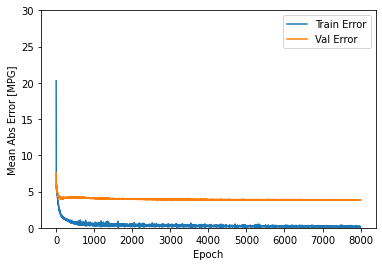

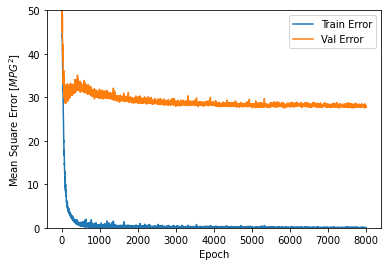

In [34]:
plot_history(history_dense, 30, 50)

In [27]:
EPOCHS = 3000
BATCH = 1
X_train, X_aux, y_train, Y_aux = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_aux, Y_aux, test_size=0.5, random_state=42, shuffle=False)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [28]:
model_lstm = build_model_lstm()
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 4)                 132       
                                                                 
Total params: 23,268
Trainable params: 23,268
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

2022-06-02 11:04:47.199143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


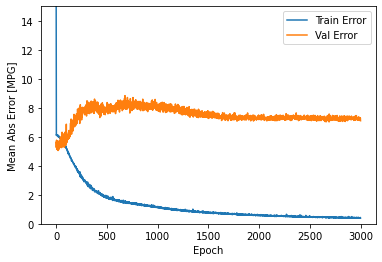

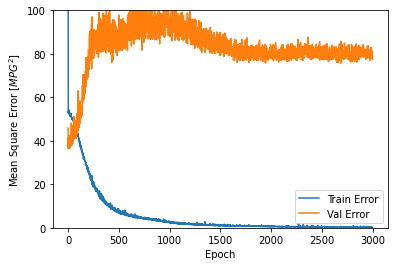

In [33]:
plot_history(history_lstm, 15, 100)

In [35]:
model_simple_rnn = build_model_simplernn()
model_simple_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 4)                 132       
                                                                 
Total params: 10,596
Trainable params: 10,596
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

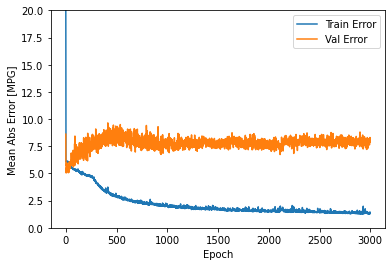

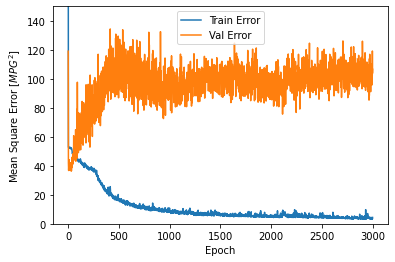

In [37]:
plot_history(history_simple_rnn, 20, 150)

In [38]:
model_dense.evaluate(X_test, y_test) 

14/14 [==============================] - 0s 822us/step - loss: 39.7124 - mae: 4.9908 - mse: 39.7124


[39.71244430541992, 4.990833759307861, 39.71244430541992]

In [39]:
model_lstm.evaluate(X_test, y_test) 

14/14 [==============================] - 0s 1ms/step - loss: 84.9838 - mae: 7.3630 - mse: 84.9838


[84.98377227783203, 7.362988471984863, 84.98377227783203]

In [40]:
model_simple_rnn.evaluate(X_test, y_test) 

14/14 [==============================] - 0s 2ms/step - loss: 94.7641 - mae: 7.7042 - mse: 94.7641


[94.76407623291016, 7.70418119430542, 94.76407623291016]

In [41]:
model_dense.save("model_dense.h5")
model_simple_rnn.save("model_simplernn.h5")
model_lstm.save("model_lstm.h5")

In [42]:
features.columns

Index(['kwh_p_tot_r', 'weather', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind', 'day', 'month', 'year', 'hour', 'minute', 'second',
       'prev_kwh_1', 'prev_kwh_2', 'prev_kwh_3', 'prev_kwh_4', 'prev_kwh_5',
       'prev_kwh_6', 'prev_kwh_7', 'prev_kwh_8'],
      dtype='object')